#### Importing libraries

In [3]:
import numpy as np
from scipy import spatial
from sklearn.neighbors import KNeighborsClassifier
import torch 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 200
batch_size = 256
data_size = 5000
verbose = True
Datapath='heloo'
dataset_path = '/content/drive/MyDrive/dataset/mnist_60000.npz'
dataset = np.load(dataset_path)
perm = np.random.permutation(len(dataset['data']))


# split data
X_train = dataset['data'][perm][:data_size]
y_train = dataset['target'][perm][:data_size]
X_test = dataset['data'][perm][data_size:data_size * 2]
y_test = dataset['target'][perm][data_size:data_size * 2]

In [4]:
X_train.shape

(5000, 784)

## Let's define our architecture

In [5]:
!pip install openTSNE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 28.3 MB/s eta 0:00:00


In [6]:
import operator
from functools import reduce

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

def get_activation(act, inplace=True):
	if act == 'lrelu':
		return nn.LeakyReLU(0.01, inplace=inplace)
	elif act == 'relu':
		return nn.ReLU(inplace=inplace)
	elif act == 'sigmoid':
		return nn.Sigmoid()
	raise Exception('unsupported activation function')

class FCEncoder(nn.Module):
	def __init__(self, dim, low_dim=2, act='lrelu'):
		super(FCEncoder, self).__init__()
		self.dim = dim
		self.act = partial(get_activation, act=act)
        
		# new network (1024 -> 512 -> 256 -> 128 -> 2)
		# new network (784 -> 392 -> 146 -> 73 -> 2)
		layers = [
			(nn.Linear(dim, 1024)),
			# (nn.BatchNorm1d(1024)),
# 			(nn.Linear(dim, 784)),            
			self.act(),
			(nn.Linear(1024, 512)),
			# (nn.BatchNorm1d(512)),
# 			(nn.Linear(dim, 392)),
			self.act(),
			(nn.Linear(512, 256)),
			# (nn.BatchNorm1d(256)),
# 			(nn.Linear(dim, 146)),            
			self.act(),
			(nn.Linear(256, 128)),
			# (nn.BatchNorm1d(128)),
# 			(nn.Linear(dim, 73)),            
			self.act(),
			(nn.Linear(128, low_dim))
		]
        
		self.net = nn.Sequential(*layers)
		
	def forward(self, X):
		return self.net(X)


## Let's call our TSNE_NN

In [7]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from openTSNE import TSNE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding
from scipy.sparse import save_npz, load_npz
import random
from functools import partial
import timeit
import math
from tqdm import tqdm


EPS = 1e-12
D_GRAD_CLIP = 1e14

class TSNE_NN():
	def __init__(self, device, n_epochs ,hidden_dim=256, n_components=2, verbose=True, batch_size=256):
		self.device = device
		self.n_epochs = n_epochs
		self.batch_size = batch_size
		self.perplexity = 20
		self.test_data = None
		self.max_grads = []
		self.epoch_losses = []
		self.verbose = verbose
		self.hidden_dim = hidden_dim
		self.n_components = n_components
	
	def fit(self, data):
		self.encoder = FCEncoder(data.shape[1], low_dim=self.n_components)
		batch_size = self.batch_size
		print('perplexity:', self.perplexity)
		
		print('calc P')
		pre_embedding = TSNE(perplexity=self.perplexity).prepare_initial(data)
		P_csc = pre_embedding.affinities.P
			
		print('Trying to put X into GPU')
		X = torch.from_numpy(data).float()
		X = X.to(self.device)
		self.X = X

		self.encoder = self.encoder.to(self.device)
		init_lr = 1e-3
		optimizer = optim.Adam(self.encoder.parameters(), lr=init_lr)
		# optimizer = optim.AdamW(self.encoder.parameters(), lr=init_lr)
		# init_lr = 1e-3
		# optimizer = optim.SGD(self.encoder.parameters(), lr=init_lr, momentum=0.9, weight_decay=5e-4) 

		lr_sched = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.n_epochs * math.ceil(len(X)/batch_size), eta_min=1e-7)
		
		def neg_squared_euc_dists(X):
			D = torch.cdist(X, X, p=2).pow(2)
			return -D

		def w_tsne(Y):
			distances = neg_squared_euc_dists(Y)
			inv_distances = 1. / (1. - (distances)) #1 / (1+d^2)
			return inv_distances
		
		def KLD(P, Q):
			x = P/Q
			if x.requires_grad:
				def hook(grad):
					self.max_grads.append(float(grad.abs().max().cpu().numpy()))
					clipped_grad = grad.clamp(min=-D_GRAD_CLIP, max=D_GRAD_CLIP)
					return clipped_grad
				x.register_hook(hook)
			return P * torch.log(x)
		
		iteration = 0
		print('optimizing...')
		pbar = tqdm(range(self.n_epochs))
		for epoch in pbar:
			iteration += 1

			idxs = torch.randperm(len(X))
			
			loss_total = []
			update_time = []
			for i in range(0, len(X), batch_size):
				start_time = timeit.default_timer()
				idx = idxs[i:i+batch_size]
				_p = torch.Tensor(P_csc[idx][:, idx].toarray()).float()
				if iteration < 250:
					_p *= 4
				p = (_p+EPS).to(self.device)
				optimizer.zero_grad()
				y = self.encoder(X[idx])
				w = w_tsne(y)
				q = w / torch.sum(w)
				loss = KLD(p, q).sum()
				loss.backward()
				loss_total.append(loss.item())
				torch.nn.utils.clip_grad_value_(self.encoder.parameters(), 4)
				optimizer.step()
				elapsed = timeit.default_timer() - start_time
				update_time.append(elapsed)
			
				lr_sched.step()
			
			self.epoch_losses.append(np.mean(loss_total))
			if (self.verbose):
				pbar.set_description("Processing epoch %03d/%03d loss : %.5f time : %.5fs" % (epoch + 1, self.n_epochs, np.mean(loss_total), np.mean(update_time)))
				# print('{:03d}/{:03d}'.format(epoch, self.n_epochs), '{:.5f}'.format(np.mean(self.loss_total)), '{:.5f}s'.format(np.mean(update_time)))
	
		with torch.no_grad():
			result = self.encoder(self.X).detach().cpu().numpy()
        	# Normalize coordinates to [0, 1]    
			result_min, result_max = result.min(), result.max()
			result_norm = (result - result_min) / (result_max - result_min)
			return result_norm

	def fit_val(self, data):
		with torch.no_grad():
			self.X = torch.from_numpy(data).float()
			self.X = self.X.to(self.device)
			result = self.encoder(self.X).detach().cpu().numpy()
			# Normalize coordinates to [0, 1]    
			result_min, result_max = result.min(), result.max()
			result_norm = (result - result_min) / (result_max - result_min)
			return result_norm

# Let's us train and check

#### Applying PCA First

In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components =2)
# X_pca = pca.fit_transform(X_test)
# # plt.scatter(X_pca[:,0],X_pca[:,1])
# scatter =plt.scatter(X_pca[:,0],X_pca[:,1],c=y_test,cmap='tab10')
# plt.legend(*scatter.legend_elements(), title='Classes')

#### Standard t-SNE 


In [ ]:
# from sklearn.manifold import TSNE
# import time

# tsne = TSNE(n_components=2)
# start_time = time.time()
# x_tsne = tsne.fit_transform(X_test)
# end_time = time.time()
# # Compute the time taken to run the function
# print("Time taken:", end_time - start_time, "seconds")

# # scatter = plt.scatter(x_tsne[:,0],x_tsne[:,1],c=y_test,cmap='tab10')
# # plt.legend(*scatter.legend_elements(), title='Classes')

In [8]:
# Setting parameters(perplexity for TSNE, n_neighbors and min_dist for UMAP)
tsne_nn = TSNE_NN(device, n_epochs=epochs, verbose = verbose, batch_size=batch_size)

# Train
X_embedded = tsne_nn.fit(X_train)

perplexity: 20
calc P
Trying to put X into GPU
optimizing...


Processing epoch 200/200 loss : -0.02110 time : 0.00478s: 100%|██████████| 200/200 [00:18<00:00, 10.59it/s]


In [9]:
import time
start_time = time.time()
X_embedded_test = tsne_nn.fit_val(X_test)
end_time = time.time()
# Compute the time taken to run the function
print("Time taken:", end_time - start_time, "seconds")

Time taken: 0.021984338760375977 seconds


In [10]:
X_embedded_test

array([[0.3753133 , 0.7355116 ],
       [0.4878679 , 0.31640804],
       [0.7441626 , 0.64787275],
       ...,
       [0.70962185, 0.55960476],
       [0.69256544, 0.744021  ],
       [0.23050652, 0.4189116 ]], dtype=float32)

In [11]:
numbers =list(range(10))
import pandas as pd
df = pd.DataFrame({'x':X_embedded_test[:,0],'y':X_embedded_test[:,1],'label':y_test})
df =df.groupby('label').mean().reset_index()
df.head()

mean_position={}
for label in df.label:
    mean_position[str(label)]=[]
    mean_position[str(label)].append(df[df['label']==label]['x'].values[0])
    mean_position[str(label)].append(df[df['label']==label]['y'].values[0])
    


# Basically trying to find the number closest to it's number
from scipy.spatial import KDTree
import numpy as np
kdtree = KDTree(X_embedded_test)
def return_index_closest_point(mean_postion,label):
    x=mean_position[label][0]
    y=mean_position[label][1]
    d, i = kdtree.query((x,y))
    return i
images = {}

for i,y in enumerate(y_test):
    if y not in images.keys():
        index = return_index_closest_point(mean_position,str(y))
        if y_test[index]==y:
            images[str(y)] = X_test[index].reshape(28,28)
    if len(images.keys())>10:
        break
print(images.keys())
for i,num in enumerate(y_test):
  if not(num in images.keys()):
        images[str(num)] = X_test[i].reshape(28,28)
print(images.keys())

dict_keys(['6', '2', '4', '1', '3', '5', '8', '7', '9', '0'])
dict_keys(['6', '2', '4', '1', '3', '5', '8', '7', '9', '0'])


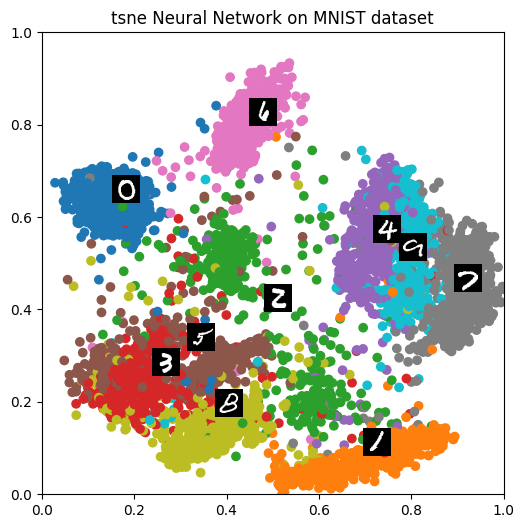

In [12]:

# Set the size of the plot in inches
fig = plt.figure(figsize=(6, 6))
plt.scatter(X_embedded_test[:,0],X_embedded_test[:,1],c=y_test,cmap='tab10')

for i in images.keys():
    x=mean_position[i][0]
    y=mean_position[i][1]
    plt.imshow(images[i], extent=[x , x+0.06, y, y+0.06],cmap='gray',zorder=10)

plt.title('tsne Neural Network on MNIST dataset')
# Set the axis limits
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


## Correctness

In [13]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier


def metric_continuity(D_high, D_low, k):
    assert D_high.shape == D_low.shape, 'D_high != D_low shape!'
    N_SAMPLES = D_high.shape[0]

    n = N_SAMPLES

    nn_orig = D_high.argsort()
    nn_proj = D_low.argsort()

    knn_orig = nn_orig[:, :k + 1][:, 1:]
    knn_proj = nn_proj[:, :k + 1][:, 1:]

    sum_i = 0

    for i in range(N_SAMPLES):
        V = np.setdiff1d(knn_orig[i], knn_proj[i])

        sum_j = 0
        for j in range(V.shape[0]):
            sum_j += np.where(nn_proj[i] == V[j])[0] - k

        sum_i += sum_j

    return float((1 - (2/(n*k*(2*n - 3*k - 1))*sum_i)).squeeze())

def metric_trustworthiness(D_high, D_low, k):
    assert D_high.shape == D_low.shape, 'D_high != D_low shape!'
    N_SAMPLES = D_high.shape[0]

    n = N_SAMPLES

    nn_orig = D_high.argsort()
    nn_proj = D_low.argsort()

    knn_orig = nn_orig[:, :k + 1][:, 1:]
    knn_proj = nn_proj[:, :k + 1][:, 1:]

    sum_i = 0

    for i in range(n):
        U = np.setdiff1d(knn_proj[i], knn_orig[i])

        sum_j = 0
        for j in range(U.shape[0]):
            sum_j += np.where(nn_orig[i] == U[j])[0] - k

        sum_i += sum_j

    return float((1 - (2/(n*k*(2*n - 3*k - 1))*sum_i)).squeeze())

def metric_neighborhood_hit(X, y, k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)

    neighbors = knn.kneighbors(X, return_distance=False)
    return np.mean(np.mean((y[neighbors] == np.tile(y.reshape((-1, 1)), k)).astype('uint8'), axis=1))


In [14]:
#High dimension
D_high_list = spatial.distance.pdist(X_test, 'euclidean')   
D_high_matrix = spatial.distance.squareform(D_high_list)    

# low dimension data"
D_low_list = spatial.distance.pdist(X_embedded_test, 'euclidean')
# print("The low dimension list mein:",len(D_low_list))
D_low_matrix = spatial.distance.squareform(D_low_list)
print("The low dimension list mein:",D_low_matrix.shape)

print("----------Evaluation----------")
# Continuity
continuity = metric_continuity(D_high_matrix, D_low_matrix, k=7)
print("Continuity = " + str(continuity))
# Trustworthiness
trustworthiness = metric_trustworthiness(D_high_matrix, D_low_matrix, k=7)
print("Trustworthiness = " + str(trustworthiness))
# Neighborhood Hit
neighborhood_hit = metric_neighborhood_hit(X_embedded_test, y_test, k=7)
print("Neighborhood Hit = " + str(neighborhood_hit))
# Average
average = (continuity + trustworthiness + neighborhood_hit) / 3
print("Average = " + str(average))


The low dimension list mein: (5000, 5000)
----------Evaluation----------
Continuity = 0.9629632276723077
Trustworthiness = 0.9147770180110529
Neighborhood Hit = 0.8529714285714286
Average = 0.9102372247515964


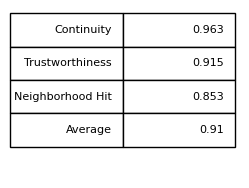

In [15]:
plt.subplot(224) 
table_data=[
    ["Continuity", round(continuity,3)],
    ["Trustworthiness", round(trustworthiness,3)],
    ["Neighborhood Hit", round(neighborhood_hit,3)],
    ["Average", round(average,3)]
]
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=table_data, loc='best')
the_table.auto_set_font_size(False)
the_table.set_fontsize(8)
the_table.scale(1, 2)
